In [1]:
import re
import pandas as pd
from collections import defaultdict

# sumy
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

# NLTK stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R (?:[A-Z-][ ]){2,}[A-Z]|"
           "E P I L O G U E)\s+" +                   # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R (?:[A-Z][ ]){2,}|"
           "This\s+book\s+was\s+art\s+directed\s+|"
           "E P I L O G U E)")                       # chapter contents ends with a new chapter, epilogue or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)
hp["Harry Potter and the Deathly Hallows"]['Epilogue'] = hp["Harry Potter and the Deathly Hallows"].pop('Chapter 37')

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
stop_words = stopwords.words('english')

In [5]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path

In [13]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
start=5; stop=35; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model
Calculating 35-topic model


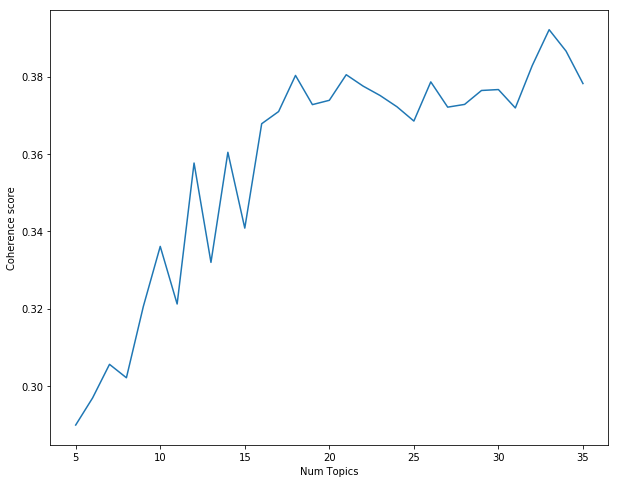

In [15]:
# Show graph
x = range(start, stop, step)
plt.figure(figsize=(10, 8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
idx = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6), '  Model index', idx)
    idx += 1

Num Topics = 5  has Coherence Value of 0.289904   Model index 0
Num Topics = 6  has Coherence Value of 0.296912   Model index 1
Num Topics = 7  has Coherence Value of 0.305602   Model index 2
Num Topics = 8  has Coherence Value of 0.302129   Model index 3
Num Topics = 9  has Coherence Value of 0.320559   Model index 4
Num Topics = 10  has Coherence Value of 0.336106   Model index 5
Num Topics = 11  has Coherence Value of 0.321205   Model index 6
Num Topics = 12  has Coherence Value of 0.357664   Model index 7
Num Topics = 13  has Coherence Value of 0.33197   Model index 8
Num Topics = 14  has Coherence Value of 0.360439   Model index 9
Num Topics = 15  has Coherence Value of 0.340833   Model index 10
Num Topics = 16  has Coherence Value of 0.367829   Model index 11
Num Topics = 17  has Coherence Value of 0.370976   Model index 12
Num Topics = 18  has Coherence Value of 0.380316   Model index 13
Num Topics = 19  has Coherence Value of 0.372771   Model index 14
Num Topics = 20  has Coher

In [17]:
# Select the model and print the topics
index = 15
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)

In [18]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percent_contribution', 'keywords', 'text']

In [20]:
bonus_words = [text.split(', ') for text in df_dominant_topic['keywords'].tolist()]

In [21]:
len(bonus_words)

199

In [22]:
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['zdfgthdvndadv']
    summarizer.null_words = stopwords.words('english')
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

In [23]:
def print_summary(summary):
    for sentence in summary:
        print(sentence)

In [24]:
doc = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('{} - {}'.format(chapter, hp[book][chapter][0]))
        words = bonus_words[doc]
        # split up bigrams used in LDA model
        words = [item for sublist in [item.split('_') for item in words] for item in sublist]
        words.extend(hp[book][chapter][0].lower().split())
        print_summary(summarize(hp[book][chapter][1], 5, words))
        doc += 1
        print()
    print()

Harry Potter and the Sorcerer's Stone
Chapter 1 - THE BOY WHO LIVED
At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls.
When Dudley had been put to bed, he went into the living room in time to catch the last report on the evening news: "And finally, bird-watchers everywhere have reported that the nation's owls have been behaving very unusually today.
Twelve times he clicked the Put-Outer, until the only lights left on the whole street were two tiny pinpricks in the distance, which were the eyes of the cat watching him.
One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours' time by Mrs. Dursley's scream as she opened the front door to put out the milk bottles, nor that he would spend the next few weeks being prodded an

At three-thirty that afternoon, Harry, Ron, and the other Gryffindors hurried down the front steps onto the grounds for their first flying lesson.
It was a clear, breezy day, and the grass rippled under their feet as they marched down the sloping lawns toward a  smooth, flat lawn on the opposite side of the grounds to the forbidden forest, whose trees were swaying darkly in the distance.
Harry caught sight of Malfoy, Crabbe, and Goyle's triumphant faces as he left, walking numbly in Professor McGonagall's wake as she strode toward the castle.
All the same, it wasn't what you'd call the perfect end to the day, Harry thought, as he lay awake much later listening to Dean and Seamus falling asleep (Neville wasn't back from the hospital wing).
Harry yelled, and the four of them sprinted down the gallery, not looking back to see whether Filch was following — they swung around the doorpost and galloped down one corridor then another, Harry in the lead, without any idea where they were or wher

"This mirror is the key to finding the Stone," Quirrell murmured, tapping his way around the frame.
shrieked Voldemort again, and Quirrell lunged, knocking Harry clean off his feet, landing on top of him, both hands around Harry's neck — Harry's scar was almost blinding him with pain, yet he could see Quirrell howling in agony.
Nevertheless, Harry, while you may only have delayed his return to power, it will merely take someone else who is prepared to fight what seems a losing battle next time — and if he is delayed again, and again, why, he may never return to power."
"Now, as I understand it, the House Cup here needs awarding, and the points stand thus: In fourth place, Gryffindor, with three hundred and twelve points; in third, Hufflepuff, with three hundred and fifty-two; Ravenclaw has four hundred and twenty-six and Slytherin, four hundred and seventy-two."
And suddenly, their wardrobes were empty, their trunks were packed, Neville's toad was found lurking in a corner of the toile

Harry was at the point of telling Ron and Hermione about Filch  and the Kwikspell course when the salamander suddenly whizzed into the air, emitting loud sparks and bangs as it whirled wildly round the room.
The sight of Percy bellowing himself hoarse at Fred and George, the spectacular display of tangerine stars showering from the salamander's mouth, and its escape into the fire, with accompanying explosions, drove both Filch and the Kwikspell envelope from Harry's mind.
The rest of the school was happily anticipating their Halloween feast; the Great Hall had been decorated with the usual live bats, Hagrid's vast pumpkins had been carved into lanterns large enough for three men to sit in, and there were rumors that Dumbledore had booked a troupe of dancing skeletons for the entertainment.
From either end of the corridor where they stood came the sound of hundreds of feet climbing the stairs, and the loud, happy talk of well-fed people; next moment, students were crashing into the pass

But something happened in their first lesson, Transfiguration, that drove the Chamber of Secrets out of their minds for the first time in weeks.
"We haven't seen her for ages, Professor," Harry went on hurriedly, treading on Ron's foot, "and we thought we'd sneak into the hospital wing, you know, and tell her the Mandrakes are nearly ready and, er, not to worry —" Professor McGonagall was still staring at him, and for a moment, Harry thought she was going to explode, but when she spoke, it was in a strangely croaky voice.
The Heir of Slytherin didn't want one anywhere near the castle once the Chamber was opened!
They marched Lockhart out of his office and down the nearest stairs, along the dark corridor where the messages shone on the wall, to the door of Moaning Myrtle's bathroom.
Harry flung his arms over his head and ran, slipping over the coils of snake skin, out of the way of great chunks of tunnel ceiling that were thundering to the floor.

Chapter 17 - THE HEIR OF SLYTHERIN
He p

Puffing loudly, Harry, Ron, and Hermione climbed the tightly spiraling steps, getting dizzier and dizzier, until at last they heard the murmur of voices above them and knew they had reached the classroom.
When Harry and Ron had had their teacups filled, they went back to their table and tried to drink the scalding tea quickly.
The book tried to bite, but Hagrid ran a giant forefinger down its spine, and the book shivered, and then fell open and lay quiet in his hand.
There was an intake of breath from behind him, and both Lavender and Parvati whispered, "Oooh, no, Harry, remember your tea leaves!"
It was nothing like a broomstick, and Harry knew which one he preferred; the hippogriff 's wings beat uncomfortably on either side of him, catching him under his legs and making him feel he was about to be thrown off; the glossy feathers slipped under his fingers and he didn't dare get a stronger grip; instead of the smooth action of his Nimbus Two Thousand, he now felt himself rocking backwa

They knew that the castle was being searched again, and the whole House stayed awake in the common room, waiting to hear whether Black had been caught.
They heard the Howler go off in the entrance hall — Neville's grandmother's voice, magically magnified to a hundred times its usual volume, shrieking about how he had brought shame on the whole family.
So at six o'clock that afternoon, Harry and Ron left Gryffindor Tower, passed the security trolls at a run, and headed down to the entrance hall.
Hermione kept shooting suspicious looks down the table at him, but he avoided her eye and was careful to let her see him walking back up the marble staircase in the entrance hall as everybody else proceeded to the front doors. "
He, Ron, and Lupin walked all the way back into the entrance hall before speaking.

Chapter 15 - THE QUIDDITCH FINAL
Harry hadn't forgotten Malfoy's attempt to sabotage him in the match against Ravenclaw, but it was the matter of Buck-beak that made him most determined t

The villagers of Little Hangleton still called it "the Riddle House," even though it had been many years since the Riddle family had lived there.
Every version of the tale, however, started in the same place: Fifty years before, at daybreak on a fine summer's morning, when the  Riddle House had still been well kept and impressive, a maid had entered the drawing room to find all three Riddles dead.
But over in the neighboring town of Great Hangleton, in the dark and dingy police station, Frank was stubbornly repeating, again and again, that he was innocent, and that the only person he had seen near the house on the day of the Riddles' deaths had been a teenage boy, a stranger, dark-haired and pale.
He reached the hall, which was a little lighter owing to the large mullioned windows on either side of the front door, and started to climb the stairs, blessing the dust that lay thick upon the stone, because it muffled the sound of his feet and stick.
The only means of escape was into the ro

It was as though the masked wizards on the ground were puppeteers, and the people above them were marionettes operated by invisible strings that rose from the wands into the air.
The crowd beneath the Roberts family was larger than ever; they could see the Ministry wizards trying to get through it to the hooded wizards in the center, but they were having great difficulty.
And something vast, green, and glittering erupted from the patch of darkness Harry's eyes had been struggling to penetrate; it flew up over the treetops and into the sky.
You seem very well informed about how that Mark is summoned, missy —" But none of the Ministry wizards apart from Mr. Crouch seemed to think it remotely likely that Harry, Ron, or Hermione had conjured the skull; on the contrary, at Hermione's words, they had all raised their wands again and were pointing in the direction she had indicated, squinting through the dark trees.
Harry heard Hermione gasp, horrified, as a gigantic serpent-tongued skull eru

Harry turned to Ron and Hermione; beyond them, he saw the long Gryffindor table all watching him, openmouthed.
Harry heard the buzzing of the hundreds of students on the other side of the wall, before Professor McGonagall closed the door.
Professor Dumbledore was now looking down at Harry, who looked right back at him, trying to discern the expression of the eyes behind the half-moon spectacles.
Insisting that he needed to sleep, and almost flattening the little Creevey brothers as they attempted to waylay him at the foot of the stairs, Harry managed to shake everyone off and climb up to the dormitory as fast as he could.
He wrenched the hangings shut around his four-poster, leaving Harry standing there by the door, staring at the dark red velvet curtains, now hiding one of the few people he had been sure would believe him.

Chapter 18 - THE WEIGHING OF THE WANDS
The prospect of going down into the Great Hall and facing the rest of the Gryffindors, all treating him like some sort of he

Ron and Harry wasted no time in telling Hermione about the conversation they had overheard between Madame Maxime and Hagrid, but Hermione didn't seem to find the news that Hagrid was a half-giant nearly as shocking as Ron did.
Rita Skeeter's smile flickered very slightly, but she hitched it back almost at once; she snapped open her crocodile-skin handbag, pulled out her Quick-Quotes Quill, and said, "How about giving me an interview about the Hagrid you know, Harry?
Hermione went slightly pink, but Dumbledore smiled at her and continued, "Hermione, Harry, and Ron still seem to want to know you, judging by the way they were attempting to break down the door."
Harry, Ron, and Hermione looked at one another nervously; Harry would rather have taken fifty Blast-Ended Skrewts for a walk than admit to Hagrid that he had overheard him talking to Madame Maxime, but Hagrid was still talking, apparently unaware that he had said anything odd.
Harry went back to the castle later that afternoon with

Voldemort bent down and pulled out Wormtail's left arm; he forced the sleeve of Wormtail's robes up past his elbow, and Harry saw something upon the skin there, something like a vivid red tattoo — a skull with a snake protruding from its mouth — the image that had appeared in the sky at the Quidditch World Cup: the Dark Mark.
The Death Eaters behind him did the same; each of them approaching Voldemort on his knees and kissing his robes, before backing away and standing up, forming a silent circle, which enclosed Tom Riddle's grave, Harry, Voldemort, and the sobbing and twitching heap that was Wormtail.
The Death Eater on the ground writhed and shrieked; Harry was sure the sound must carry to the houses around.
The Death Eaters were quite motionless, the glittering eyes in their masks fixed upon Voldemort, and upon Harry.
Use my Death Eater to ensure that the boy won the tournament — that he touched the Triwizard Cup first — the cup which my Death Eater had turned into a Portkey, which 

A few minutes later he heard the slamming of car doors, the rumble of an engine, and the unmistakable sound of the car sweeping out of the drive.
The room grew steadily darker around him as he lay listening to the night sounds through the window he kept open all the time, waiting for the blessed moment when Hedwig returned.
Here you go —" He rapped Harry hard on the top of the head and Harry felt a curious sensation as though Moody had just smashed an egg there; cold trickles seemed to be running down his body from the point the wand had struck.
and Harry laughed aloud at the thought, though his voice was drowned by the flapping of the others' robes, the creaking of the harness holding his trunk and the cage, the whoosh of the wind in their ears as they sped through the air.
The grimy fronts of the surrounding houses were not welcoming; some of them had broken windows, glimmering dully in the light from the street-lamps, paint was peeling from many of the doors, and heaps of rubbish la

With a grin at the thought of what Hermione would say if she could see the statue of the elf, Harry turned his money bag upside down and emptied not just ten Galleons, but the whole contents into the pool at the statues' feet.
Mrs. Weasley was wiping her face on her apron, and Fred, George, and Ginny were doing a kind of war dance to a chant that went "He got off, he got off, he got off —" "That's enough, settle down!"
Molly, I'll be late, I'm covering for Tonks, but Kingsley might be dropping in for dinner —" "He got off, he got off, he got off —" "That's enough — Fred — George — Ginny!"
Though members of the Order of the Phoenix came and went regularly, sometimes staying for meals, sometimes only for a few minutes' whispered conversation, Mrs. Weasley made sure that Harry and the others were kept well out of earshot (whether Extendable or normal) and nobody, not even Sirius, seemed to feel that Harry needed to know anything more than he had heard on the night of his arrival.
The Orde

Harry felt happier for the rest of the weekend than he had done all term.
The above is in accordance with Educational Decree Number Twenty-four.
"Yes," said Harry, lifting Hedwig carefully off his shoulder, "she turned up after the other post owls and her wing's all funny, look —" Professor Grubbly-Plank stuck her pipe firmly between her teeth and took Hedwig from Harry while Professor McGonagall watched.
A hand had appeared amongst the flames, groping as though to catch hold of something; a stubby, short-fingered hand covered in ugly old-fashioned rings.
Umbridge's hand was still making snatching movements amongst the flames, as though she knew exactly where Sirius's hair had been moments before and was determined to seize it.

Chapter 18 - DUMBLEDORE'S ARMY
said Professor Flitwick's squeaky little voice and Harry, Ron, and Hermione all jumped.
"Mimbulus mimbletonia," said Ron's voice and Harry came back to his senses just in time to clamber through the portrait hole into the common r

"You know," said Sirius loudly, leaning back on his rear chair legs and speaking to the ceiling, "I think I'd prefer it if you didn't give orders here, Snape.
"I am here on Dumbledore's orders," said Snape, whose voice, by contrast, was becoming more and more quietly waspish, "but by all means stay, Black, I know you like to feel .
Harry was separated from him by Mundungus and Mad-Eye, who had dropped in to offer Mr. Weasley their congratulations; he wanted to talk to Sirius, to tell him that he should not listen to a word Snape said, that Snape was goading him deliberately and that the rest of them did not think Sirius was a coward for doing as Dumbledore told him and remaining in Grimmauld Place, but he had no opportunity to do so, and wondered occasionally, eyeing the ugly look on Sirius's face, whether he would have dared to even if he had the chance.
He had a bad feeling about this parting; he did not know when they would next see each other and felt that it was incumbent upon him

The purposeful, feverish atmosphere drove nearly everything but the O.W.L.s from Harry's mind, though he did wonder occasionally during Potions lessons whether Lupin had ever told Snape that he must continue giving Harry Occlumency tuition: If he had, then Snape had ignored Lupin as thoroughly as he was now ignoring Harry.
Harry thought Professor Marchbanks must be the tiny, stooped witch with a face so lined it looked as though it had been draped in cobwebs; Umbridge was speaking to her very deferentially.
said Professor Umbridge as Harry, Ron, and Hermione dragged their feet up the marble staircase as slowly as they dared, "let me show you to the staffroom .
Ten minutes later, Professor Flitwick called, "Parkinson, Pansy — Patil, Padma — Patil, Parvati — Potter, Harry."
"Professor Tofty is free, Potter," squeaked Professor Flitwick, who was standing just inside the door.

Chapter 32 - OUT OF THE FIRE
He waited for the second when the old man's heels disappeared over the threshold int

"And this ability of yours — to detect Voldemort's presence, even when he is disguised, and to know what he is feeling when his emotions are roused — has become more and more pronounced since Voldemort returned to his own body and his full powers."
"I cared more for your happiness than your knowing the truth, more for your peace of mind than my plan, more for your life than the lives that might be lost if the plan failed.
"It meant," said Dumbledore, "that the person who has the only chance of conquering Lord Voldemort for good was born at the end of July, nearly sixteen years ago.
"But you said — Neville was born at the end of July too — and his mum and dad —" "You are forgetting the next part of the prophecy, the final identifying feature of the boy who could vanquish Voldemort.
He did not know that you would have 'power the Dark Lord knows not' —" "But I don't!"

Chapter 38 - THE SECOND WAR BEGINS
Meanwhile the Boy Who Lived — "There you are, Harry, I knew they'd drag you into it so

Harry spent a lot of the last week of the holidays pondering the meaning of Malfoy's behavior in Knockturn Alley.
Harry had thought it through carefully and come to the conclusion that, if he was to tell anyone, Mr. Weasley was the right person; firstly, because he worked at the Ministry and was therefore in the best position to make further investigations, and secondly, because he thought that there was not too much risk of Mr. Weasley exploding with anger.
Harry, I would be delighted if you would join me for a bite of lunch in compartment C. Sincerely, Professor H. E. F. Slughorn "Who's Professor Slughorn?"
When they reached compartment C, they saw at once that they were not Slughorn's only invitees, although judging by the enthusiasm of Slughorn's welcome, Harry was the most warmly anticipated.
Harry seized the door and pushed it open, hard; Zabini, still clinging on to the handle, toppled over sideways into Gregory Goyle's lap, and in the ensuing ruckus, Harry darted into the compa

Katie Bell was still in St. Mungo's Hospital with no prospect of leaving, which meant that the promising Gryffindor team Harry had been training so carefully since September was one Chaser short.
As Harry had endured much worse mutterings than this in his school career, he was not particularly bothered, but all the same, the pressure was increasing to provide a win in the upcoming match against Slytherin.
If Gryffindor won, Harry knew that the whole House would forget that they had criticized him and swear that they had always known it was a great team.
He gave Harry a shifty grin that Harry did not return, as the newborn monster inside him was roaring for Dean's instant dismissal from the team.
As the crowd shrieked and laughed, the Gryffindor team landed beside the wreckage of wood under which Zacharias was feebly stirring; Harry heard Ginny saying blithely to an irate Professor McGonagall, "Forgot to brake, Professor, sorry."

Chapter 15 - THE UNBREAKABLE VOW
Hagrid had already sing

Harry wracked his brains over the next week as to how he was to persuade Slughorn to hand over the true memory, but nothing in the nature of a brain wave occurred and he was reduced to doing what he did increasingly these days when at a loss: poring over his Potions book, hoping that the Prince would have scribbled something useful in a margin, as he had done so many times before.
He lay awake for what felt like hours, wondering how Malfoy was using the Room of Requirement and what he, Harry, would see when he went in there the following day, for whatever Hermione said, Harry was sure that if Malfoy had been able to see the headquarters of the D.A., he would be able to see Malfoy's .
Hermione set off immediately for Ancient Runes; Ron for the common room, where he still had to finish his conclusion on Snape's dementor essay; and Harry for the corridor on the seventh floor and the stretch of wall opposite the tapestry of Barnabas the Barmy teaching trolls to do ballet.
When the bell sou

Harry scrambled up from the floor and began to sprint along the corridor, ignoring the bangs issuing from behind him, the yells of the others to come back, and the mute call of the figures on the ground whose fate he did not yet know.
He could hear nothing but his own pounding feet, his own hammering heart as he sprinted along the next empty corridor, but then spotted a bloody footprint that showed at least one of the fleeing Death Eaters was heading toward the front doors — perhaps the Room of Requirement was indeed blocked — He skidded around another corner and a curse flew past him; he dived behind a suit of armor that exploded.
Harry flew across the entrance hall and out into the dark grounds: He could just make out three figures racing across the lawn, heading for the gates beyond which they could Disapparate — by the looks of them, the huge blond Death Eater and, some way ahead of him, Snape and Malfoy .
Something caught Harry hard in the small of the back and he fell forward, hi

"Voldemort —" "Easy, now," said Ted Tonks, placing a hand on Harry's shoulder and pushing him back against the cushions.
Throwing aside the no longer glowing hairbrush, Harry stood up, swaying slightly, and saw Mrs. Weasley and Ginny running down the steps by the back door as Hagrid, who had also collapsed on landing, clambered laboriously to his feet.
As the lamplight fell across George's head, Ginny gasped and Harry's stomach lurched: One of George's ears was missing.
No sooner had Mrs. Weasley bent over her son than Lupin grabbed Harry by the upper arm and dragged him, none too gently, back into the kitchen, where Hagrid was still attempting to ease his bulk through the back door.
Glad of something to do, Harry pulled him free, then headed through the empty kitchen and back into the sitting room, where Mrs. Weasley and Ginny were still tending to George.

Chapter 6 - THE GHOUL IN PAJAMAS
The shock of losing Mad-Eye hung over the house in the days that followed; Harry kept expecting 

The usual low whisper of "Severus Snape?"
"'Severus Snape, long-standing Potions master at Hogwarts School of Witchcraft and Wizardry, was today appointed headmaster in the most important of several staffing changes at the ancient school.
Snape, headmaster!
They won't accept Snape as headmaster.
The painted image of Phineas Nigellus Black was able to flit between his portrait in Grimmauld Place and the one that hung in the headmaster's office at Hogwarts: the circular tower-top room where Snape was no doubt sitting right now, in triumphant possession of Dumbledore's collection of delicate, silver magical instruments, the stone Pensieve, the Sorting Hat and, unless it had been moved elsewhere, the sword of Gryffindor.

Chapter 13 - THE MUGGLE-BORN REGISTRATION COMMISSION
As he passed gleaming wooden door after gleaming wooden door, each bearing a small plaque with the owner's name and occupation upon it, the might of the Ministry, its complexity, its impenetrability, seemed to force its

Harry had finally managed to tell Ron the whole story of his and Hermione's various wanderings, right up to the full story of what had happened at Godric's Hollow; Ron was now filling Harry in on everything he had discovered about the wider Wizarding world during his weeks away.
"I want to go and see Xenophilius Lovegood."
"It won't be like Godric's Hollow," Ron added, "Lovegood's on your side, Harry, The Quibbler's been for you all along, it keeps telling everyone they've got to help you!"
"The Crumple-Horned Snorkack," said Xenophilius very clearly, a mulish look upon his face, "is a shy and highly magical creature, and its horn —" "Mr. Lovegood, I recognize the grooved markings around the base, that's an Erumpent horn and it's incredibly dangerous — I don't know where you got it —" "I bought it," said Xenophilius dogmatically, "two weeks ago, from a delightful young wizard who knew of my interest in the exquisite Snorkack.
"Well," said Harry, glancing at Hermione, who nodded encoura

He saw the achingly familiar Hogsmeade High Street: dark shop fronts, and the outline of black mountains beyond the village, and the curve in the road ahead that led off toward Hogwarts, and light spilling from the windows of the Three Broomsticks, and with a lurch of the heart he remembered, with piercing accuracy, how he had landed here nearly a year before, supporting a desperately weak Dumbledore; all this in a second, upon landing — and then, even as he relaxed his grip upon Ron's and Hermione's arms, it happened.
Even as he looked at the other two beneath the Cloak, the door of the Three Broomsticks burst open and a dozen cloaked and hooded Death Eaters dashed into the street, their wands aloft.
The dementors had retreated, the stars were popping out again, and the footsteps of the Death Eaters were becoming louder; but before Harry in his panic could decide what to do, there was a grinding of bolts nearby, a door opened on the left-hand side of the narrow street, and a rough voi

Harry clutched the Cloak tightly around him in the darkness, traveling deeper and deeper into the forest, with no idea where exactly Voldemort was, but sure that he would find him.
The dead who walked beside him through the forest were much more real to him now than the living back at the castle: Ron, Hermione, Ginny, and all the others were the ones who felt like ghosts as he stumbled and slipped toward the end of his life, toward Voldemort.
Two figures emerged from behind a nearby tree: Their wands flared, and Harry saw Yaxley and Dolohov peering into the darkness, directly at the place Harry, his mother and father and Sirius and Lupin stood.
They had traveled on mere minutes when Harry saw light ahead, and Yaxley and Dolohov stepped out into a clearing that Harry knew had been the place where the monstrous Aragog had once lived.
Voldemort had frozen where he stood, but his red eyes had found Harry, and he stared as Harry moved toward him, with nothing but the fire between them.

Cha